## niphlem signal processing and peak detection

This notebook uses sample data to demonstrate use of the niphlem toolbox for ECG signal processing and peak detection.

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import sys
from niphlem.clean import butter_bandpass_filter
from niphlem.events import peakdet, compute_max_events
from niphlem.input_data import get_lines, load_cmrr_info, load_cmrr_data
from outliers import smirnov_grubbs as grubbs
from scipy.signal import welch

In /Users/amy/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/amy/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/amy/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/amy/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/amy/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-d

#### Load sample ECG data

In [2]:
%%time
traces, meta_info = load_cmrr_info("./sample_data/Physio_sample1_Info.log")
signal, info_dict = load_cmrr_data("./sample_data/Physio_sample1_ECG.log", "ECG", meta_info, sync_scan=False) 

ecg_signal=signal
print(ecg_signal[:10,:])
print("")

fs = 400
low_cut = 0.6
high_cut = 5.0
delta = 200
peak_rise = 0.75

print("ECG sampling rate: %.2f Hz,\n"
      "lower bandpass freq: %.2f Hz,\n"
      "higher bandpass freq: %.2f Hz,\n"
      "peak min separation: %.2f,\n"
      "relative peak height: %.2f,\n" % (fs, low_cut, high_cut, delta, peak_rise))


[[2970. 2817. 1905. 1828.]
 [3004. 2827. 1880. 1825.]
 [2992. 2797. 1862. 1831.]
 [2941. 2736. 1850. 1846.]
 [2861. 2652. 1844. 1865.]
 [2763. 2553. 1841. 1888.]
 [2653. 2446. 1837. 1909.]
 [2542. 2339. 1833. 1928.]
 [2440. 2236. 1831. 1942.]
 [2353. 2153. 1834. 1951.]]

ECG sampling rate: 400.00 Hz,
lower bandpass freq: 0.60 Hz,
higher bandpass freq: 5.00 Hz,
peak min separation: 200.00,
relative peak height: 0.75,

CPU times: user 2.63 s, sys: 105 ms, total: 2.73 s
Wall time: 2.8 s


#### Filter ECG signal, perform peak detection

Set electrode 1 as ground, subtract from electrodes 2-4. Filter signals and average. 

In [3]:
ground_ecg = ecg_signal[:,0] #electrode 1 as ground 
signals = np.zeros(shape=(ground_ecg.size, 3))
signals_filt = np.zeros(shape=(ground_ecg.size, 3))
for ii in range(1,4):
    signals[:,ii-1] = ecg_signal[:,ii] - ground_ecg
    signals[:,ii-1] = signals[:,ii-1] - np.mean(signals[:,ii-1])
    signals_filt[:,ii-1] = butter_bandpass_filter(signals[:,ii-1],lowcut=low_cut, highcut=high_cut, fs=fs)

mean_signal = np.average(signals,axis=1)
mean_signal_filt = np.average(signals_filt,axis=1)

Plot unfiltered, filtered signals and power spectrum. 

Perform peak detection and plot snapshot of timeseries with peaks marked.

Plot average QRS signal, RR interval histogram and instantaneous heart rate.

Filtered electrodes mean
Mean HR = 64.78 bpm, RR interval SNR = 8.75


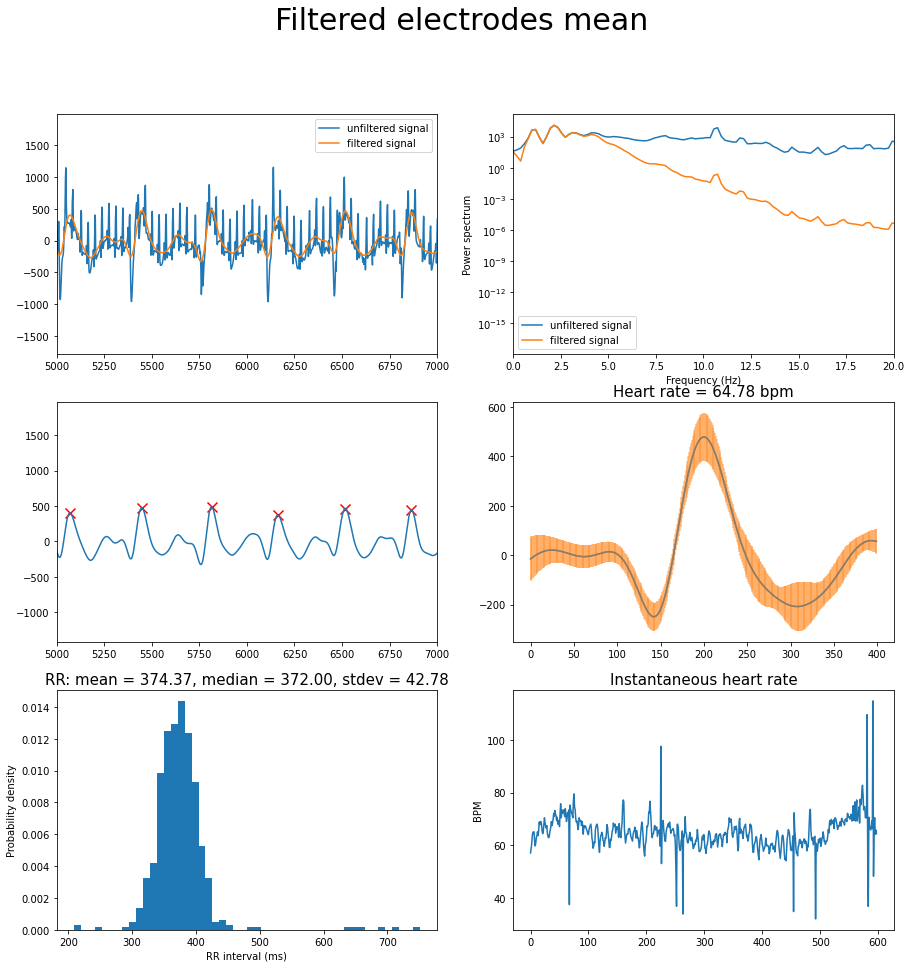

In [4]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15,15))
# Plot signal for 5 seconds signal
ax = axs[0,0]
ax.plot(mean_signal, label="unfiltered signal")
ax.plot(mean_signal_filt, label="filtered signal")
ax.set_xlim([5000, 7000])
ax.legend()

# Show how frequencies are filtered 
ax = axs[0,1]
f, Pxx = welch(mean_signal, fs=fs, nperseg=2048, scaling="spectrum")
ax.semilogy(f, Pxx, label="unfiltered signal")
f, Pxx = welch(mean_signal_filt, fs=fs, nperseg=2048, scaling="spectrum")
ax.semilogy(f, Pxx, label="filtered signal")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power spectrum")
ax.set_xlim([0,20])
ax.legend()

# Compute peaks and plot a portion of data (5 secs)
ax = axs[1,0]
peaks = compute_max_events(mean_signal_filt, peak_rise=peak_rise, delta=delta)
diff_peaks = abs(np.diff(peaks))

# Heart rate using the difference time between peaks
heart_rate = np.mean(fs/diff_peaks)*60

ax.plot(mean_signal_filt)
ax.scatter(peaks.astype(int), mean_signal_filt[peaks.astype(int)], c="red", marker="x", s=100)
ax.set_xlim([5000, 7000])

# Compute signal around peaks
ax = axs[1,1]

sign_peaks = []
for pk in peaks.astype(int):
    i_0 = pk-delta
    i_f = pk+delta
    if i_0 < 0:
        continue
    if i_f > len(mean_signal_filt):
        continue
    sign_peaks.append(mean_signal_filt[i_0:i_f])

ax.plot(np.mean(np.array(sign_peaks), axis=0))
ax.errorbar(x=np.arange(2*delta),
         y = np.mean(np.array(sign_peaks), axis=0),
         yerr = np.std(np.array(sign_peaks), axis=0),
            alpha=0.5
        )
ax.set_title("Heart rate = %.2f bpm" % heart_rate, size=15)    

# Compute peaks and plot histogram of RR interval
ax = axs[2,0]
ax.hist(diff_peaks, bins=50, density=True)

# Compute mean, median, stdev of RR interval
mean_RR = np.mean(diff_peaks)
median_RR = np.median(diff_peaks)
stdev_RR = np.std(diff_peaks)
ax.set_title("RR: mean = %.2f, median = %.2f, stdev = %.2f" % (mean_RR, median_RR, stdev_RR), size=15)
ax.set_xlabel("RR interval (ms)")
ax.set_ylabel("Probability density")

# Compute and plot instantaneous HR
inst_hr = (fs/diff_peaks)*60

ax = axs[2,1]
ax.plot(inst_hr)
ax.set_title("Instantaneous heart rate", size=15)
#ax.set_xlabel("RR interval number")
ax.set_ylabel("BPM")

# Compute SNR
snr_RR = mean_RR/stdev_RR
    
plt.suptitle("Filtered electrodes mean", size=30)

print("Filtered electrodes mean")
print("Mean HR = %.2f bpm, RR interval SNR = %.2f" % (heart_rate, snr_RR))



#### Correct anomalies/artifacts in instantaneous heart rate

Perform one-sided [Grubb's test](https://en.wikipedia.org/wiki/Grubbs%27s_test) to detect RR interval outliers that are too large and result in a very slow instantaneous heart rate

In [5]:
# first correct for max outliers, then perform min test on corrected peaks dataset 
max_indices = grubbs.max_test_indices(diff_peaks, alpha=0.05)
print(max_indices) # RR intervals that are too long, resulting in very slow instantaneous heart rate

[492, 263, 454, 583, 252, 67, 592, 251]


Correct these max outliers by inserting a new peak halfway through the RR interval

In [6]:
# insert new peak halfway between too long RR interval
too_slow = np.array(max_indices)
new_peaks = np.zeros_like(too_slow, dtype=float)

for index,i in enumerate(too_slow):
    new_diff = (peaks[i+1] - peaks[i])/2 #new diff_peak 
    new_peak = peaks[i] + new_diff #new peak to insert into corrected peaks array
    new_peaks[index] = new_peak

corrected_peaks = np.insert(peaks, (too_slow+1).reshape(-1), new_peaks.reshape(-1))
corrected_diff_peaks = abs(np.diff(corrected_peaks))

mean_RR = np.mean(corrected_diff_peaks)

Perform one-sided Grubb's test to detect RR interval outliers that are too small and result in a very fast instantaneous heart rate

In [7]:
# perform min grubbs test on corrected peaks and remove too fast from the new corrected peaks dataset
min_indices = grubbs.min_test_indices(corrected_diff_peaks, alpha=0.05)
print(min_indices) # RR intervals that are too short, resulting in very fast instantaneous heart rate

[598, 587, 252, 253, 226, 599, 600]


Correct these min outliers by replacing the peak with a new peak halfway through the RR interval (e.g. remove peak $x$, insert new peak halfway beween peak $x$ and peak $x+2$)

In [8]:
# deleting peak such that resultant RR interval is furthest from mean RR (i.e. gives longer RR interval)
too_fast = np.array(min_indices)
peaks_to_replace = np.zeros_like(too_fast) #index of peaks to delete (and then reinsert)
new_peaks2 = np.zeros_like(too_fast, dtype=float)

for index,i in enumerate(too_fast):
    
    #print(index, i)
    if i == (corrected_diff_peaks.size - 1): #if last RR interval (edge case)
        peaks_to_replace[index] = i #replace first peak
        #print("replacing first peak by default (last RR interval)")
        new_diff = (corrected_peaks[i+1] - corrected_peaks[i-1])/2 #new diff_peak
        new_peaks2[index] = corrected_peaks[i-1] + new_diff
        #print("replacing first peak")
        #print("new diff", new_diff)
    else:
        new_diff1 = corrected_peaks[i+1] - corrected_peaks[i-1] #replace first peak
        new_diff2 = corrected_peaks[i+2] - corrected_peaks[i] #replace second peak
        #print("new_diff1", new_diff1)
        #print("new_diff2", new_diff2)

        if (new_diff1 - mean_RR) > (new_diff2 - mean_RR):
            peaks_to_replace[index] = i #replacing first peak results in new RR interval furthest from mean RR interval
            new_diff = (corrected_peaks[i+1] - corrected_peaks[i-1])/2 #new diff_peak
            new_peaks2[index] = corrected_peaks[i-1] + new_diff
            #print("replacing first peak")
            #print("new diff", new_diff)
        else:
            peaks_to_replace[index] = i+1 #replacing second peak results in new RR interval furthest from mean RR interval
            new_diff = (corrected_peaks[i+2] - corrected_peaks[i])/2 #new diff_peak
            new_peaks2[index] = corrected_peaks[i] + new_diff
            #print("replacing second peak")
            #print("new diff", new_diff)

#print("peaks to replace (indices)", peaks_to_replace)
corrected_peaks2 = corrected_peaks.copy()
np.put(corrected_peaks2, peaks_to_replace, new_peaks2)
corrected_diff_peaks2 = abs(np.diff(corrected_peaks2))

Perform peak detection on corrected timeseries and plot snapshot of timeseries with peaks marked.

Plot corrected average QRS signal, RR interval histogram and instantaneous heart rate.

Filtered electrode mean (corrected):
Mean HR = 65.35 bpm, RR interval SNR = 13.22


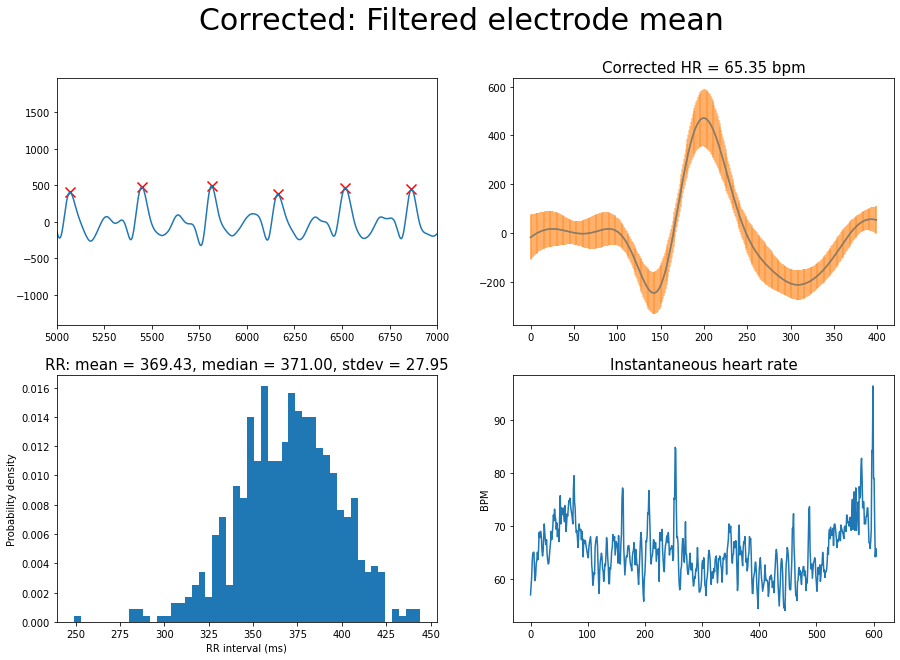

In [9]:
# fully corrected plots
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,10))

# Compute peaks and plot a portion of data (5 secs)
ax = axs[0,0]

# Heart rate using the difference time between peaks
corrected_heart_rate = np.mean(fs/corrected_diff_peaks2)*60

ax.plot(mean_signal_filt)
ax.scatter(corrected_peaks2.astype(int), mean_signal_filt[corrected_peaks2.astype(int)], c="red", marker="x", s=100)
ax.set_xlim([5000, 7000])

# Compute signal around peaks
ax = axs[0,1]

corrected_sign_peaks = []
for pk in corrected_peaks2.astype(int):
    i_0 = pk-delta
    i_f = pk+delta
    if i_0 < 0:
        continue
    if i_f > len(mean_signal_filt):
        continue
    corrected_sign_peaks.append(mean_signal_filt[i_0:i_f])

ax.plot(np.mean(np.array(corrected_sign_peaks), axis=0))
ax.errorbar(x=np.arange(2*delta),
         y = np.mean(np.array(corrected_sign_peaks), axis=0),
         yerr = np.std(np.array(corrected_sign_peaks), axis=0),
            alpha=0.5
        )

ax.set_title("Corrected HR = %.2f bpm" % corrected_heart_rate, size=15)

# Compute peaks and plot histogram of RR interval
ax = axs[1,0]
ax.hist(corrected_diff_peaks2, bins=50, density=True)

# Compute mean, median, stdev of RR interval
corrected_mean_RR = np.mean(corrected_diff_peaks2)
corrected_median_RR = np.median(corrected_diff_peaks2)
corrected_stdev_RR = np.std(corrected_diff_peaks2)
ax.set_title("RR: mean = %.2f, median = %.2f, stdev = %.2f" % (corrected_mean_RR, corrected_median_RR, corrected_stdev_RR), size=15)
ax.set_xlabel("RR interval (ms)")
ax.set_ylabel("Probability density")

# Compute and plot instantaneous HR
corrected_inst_hr = (fs/corrected_diff_peaks2)*60

ax = axs[1,1]
ax.plot(corrected_inst_hr)
ax.set_title("Instantaneous heart rate", size=15)
#ax.set_xlabel("RR interval number")
ax.set_ylabel("BPM")

# Compute SNR
corrected_snr_RR = corrected_mean_RR/corrected_stdev_RR

plt.suptitle("Corrected: Filtered electrode mean", size=30)

print("Filtered electrode mean (corrected):")
print("Mean HR = %.2f bpm, RR interval SNR = %.2f" % (corrected_heart_rate, corrected_snr_RR))

#### Compare pre and post corrected graphs

Side-by-side comparison of average QRS, RR interval histogram and instantaneous heart rate before (left) and after (right) anomaly/artifact correction

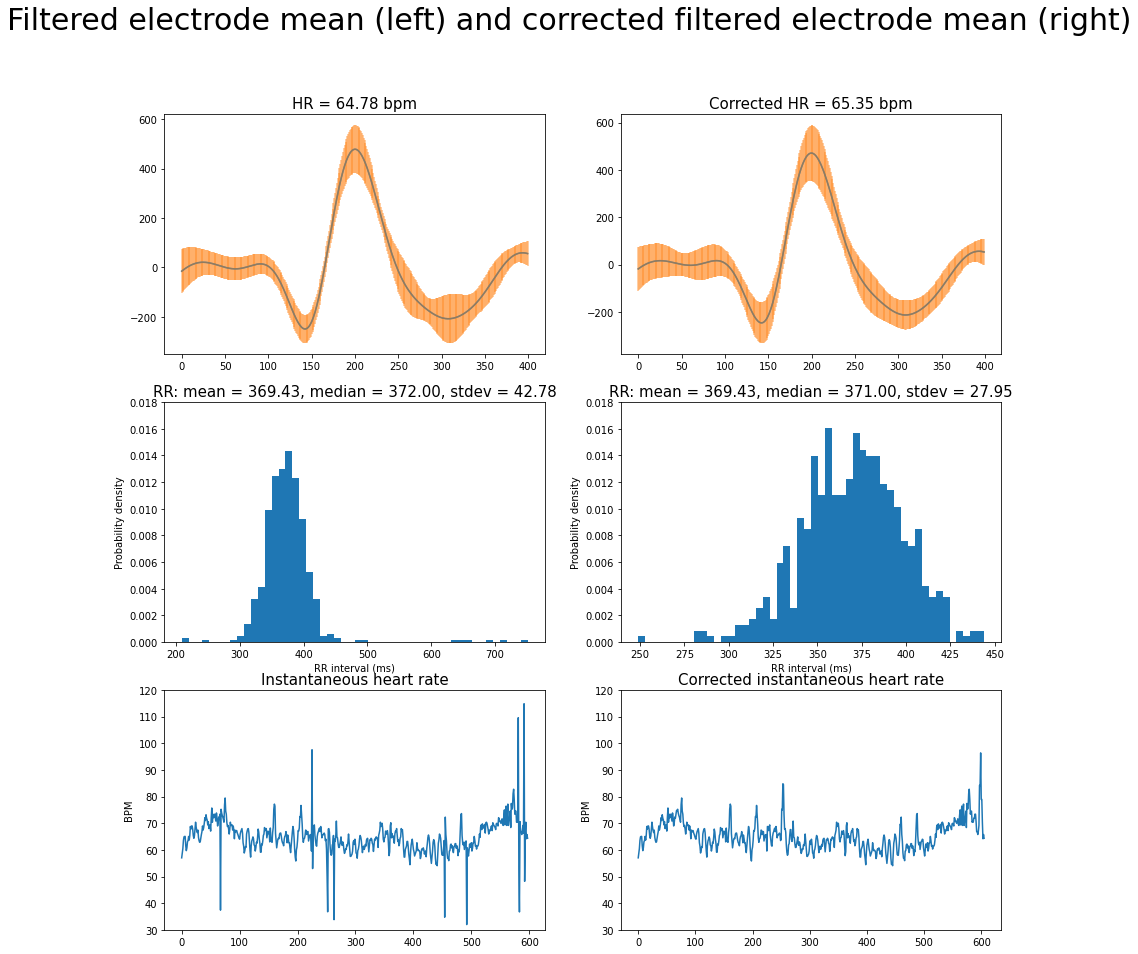

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15,15))

# Plot average QRS

ax = axs[0,0]
ax.plot(np.mean(np.array(sign_peaks), axis=0))
ax.errorbar(x=np.arange(2*delta),
            y = np.mean(np.array(sign_peaks), axis=0),
            yerr = np.std(np.array(sign_peaks), axis=0),
            alpha=0.5
        )

ax.set_title("HR = %.2f bpm" % heart_rate, size=15)

ax = axs[0,1]
ax.plot(np.mean(np.array(corrected_sign_peaks), axis=0))
ax.errorbar(x=np.arange(2*delta),
            y = np.mean(np.array(corrected_sign_peaks), axis=0),
            yerr = np.std(np.array(corrected_sign_peaks), axis=0),
            alpha=0.5
        )

ax.set_title("Corrected HR = %.2f bpm" % corrected_heart_rate, size=15)

# Plot histogram of RR interval

ax = axs[1,0]
ax.hist(diff_peaks, bins=50, density=True)
ax.set_ylim(0,0.018)
ax.set_title("RR: mean = %.2f, median = %.2f, stdev = %.2f" % (mean_RR, median_RR, stdev_RR), size=15)
ax.set_xlabel("RR interval (ms)")
ax.set_ylabel("Probability density")

ax = axs[1,1]
ax.hist(corrected_diff_peaks2, bins=50, density=True)
ax.set_ylim(0,0.018)
ax.set_title("RR: mean = %.2f, median = %.2f, stdev = %.2f" % (corrected_mean_RR, corrected_median_RR, corrected_stdev_RR), size=15)
ax.set_xlabel("RR interval (ms)")
ax.set_ylabel("Probability density")

# Plot instantaneous HR
ax = axs[2,0]
ax.plot(inst_hr)
ax.set_ylim(30,120)
ax.set_title("Instantaneous heart rate", size=15)
#ax.set_xlabel("RR interval number")
ax.set_ylabel("BPM")

ax = axs[2,1]
ax.plot(corrected_inst_hr)
ax.set_ylim(30,120)
ax.set_title("Corrected instantaneous heart rate", size=15)
#ax.set_xlabel("RR interval number")
ax.set_ylabel("BPM")

plt.suptitle("Filtered electrode mean (left) and corrected filtered electrode mean (right)", size=30)
plt.show()